# Notebook 2: Expériences sur les modèles

**Auteurs:**  

Akram Farihi, Sami Abloui, Amalya Mourih 

**Objectifs de notebook:**

Dans ce notebook, nous réalisons l'entraînement sur les modèles choisis avec accomagnement de MLFlows et le reste. Nous avons le code preprocessing.py qui permettra de faire le prétraiment des données. et nous allons effectue nos expéricences



In [1]:
# les lib importé 
from sys import path

path.append('..')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from data.preprocessing  import preprocess_data

print("Les bibliothèques sont importées avec succès.")

Les bibliothèques sont importées avec succès.


Preprocessing data avant de pouvoir l'entraineer

In [3]:
from data.data_loader import load_data
df_raw = load_data()
print("Données chargées avec succès.")

print("\n Prétraitement des données...")
print("\n -------------------------------------------------------------------------")
df = preprocess_data(df_raw)
print("Prétraitement des données terminé.")
print("Aperçu des données prétraitées:")
df.head()

Données chargées avec succès.

 Prétraitement des données...

 -------------------------------------------------------------------------
   ID  Age  Gender  Country  Coffee_Intake  Caffeine_mg  Sleep_Hours  \
0   1   40    Male  Germany            3.5        328.1          7.5   
1   2   33    Male  Germany            1.0         94.1          6.2   
2   3   42    Male   Brazil            5.3        503.7          5.9   
3   4   53    Male  Germany            2.6        249.2          7.3   
4   5   32  Female    Spain            3.1        298.0          5.3   

  Sleep_Quality   BMI  Heart_Rate Stress_Level  Physical_Activity_Hours  \
0          Good  24.9          78          Low                     14.5   
1          Good  20.0          67          Low                     11.0   
2          Fair  22.7          59       Medium                     11.2   
3          Good  24.7          71          Low                      6.6   
4          Fair  24.1          76       Medium         

,Gender,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption,Age_Group,Continent
0,1,3.5,328.1,7.5,2,24.9,78,0,14.5,0,2,0,0,2,2
1,1,1.0,94.1,6.2,2,20.0,67,0,11.0,0,3,0,0,2,2
2,1,5.3,503.7,5.9,1,22.7,59,1,11.2,1,1,0,0,2,0
3,1,2.6,249.2,7.3,2,24.7,71,0,6.6,1,2,0,0,3,2
4,0,3.1,298.0,5.3,1,24.1,76,1,8.5,1,4,0,1,2,2


In [4]:

X = df.drop(columns=['Sleep_Quality'])
y = df['Sleep_Quality']

# appliquer une répartition stratifiée car nos données sont déséquilibrées

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) 

Nous allons ensuite construire un pipeline afin d’automatiser la normalisation des données, l’entraînement des modèles et la définition des bonnes grilles de paramètres. Nous avons choisi d’utiliser des modèles de classification plutôt que des modèles de régression, car notre objectif est de prédire une classe. Trois approches seront donc évaluées :

- SVM, un classifieur performant et adapté aux jeux de données de taille moyenne.

- RandomForest, 

- MLP, un réseau de neurones adapté aux données tabulaires, contrairement aux CNN destinés aux images et aux RNN conçus pour les données séquentielles.

In [40]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

pipelines = {
    "rf": Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", RandomForestClassifier())
    ]),
    "svm": Pipeline([
        ("scaler", StandardScaler()),
        ("model", SVC(probability=True))
    ]),
    "mlp": Pipeline([
        ("scaler", StandardScaler()),
        ("model", MLPClassifier(max_iter=300))
    ])
}

param_grids = {
    "rf": {
        "model__n_estimators": [100, 200, 300],      
        "model__max_depth": [None, 5, 10, 20],       
        "model__min_samples_split": [2, 5, 10],      
        "model__min_samples_leaf": [1, 2, 4],       
        "model__bootstrap": [True, False]            
    },
    "svm": {
        "model__C": [0.1, 1, 10],
        "model__kernel": ["rbf", "linear"]
    },
    "mlp": {
        "model__hidden_layer_sizes": [(50,), (100,), (50,50)],
        "model__activation": ["relu", "tanh"],
        "model__alpha": [0.0001, 0.001]
    }
}

In [41]:

import sys
import os
sys.path.append(os.path.abspath("."))  # racine du projet


In [43]:
import os
os.getcwd()  # doit afficher C:\Users\akram\Processus_data


'C:\\Users\\akram\\Processus_data'

In [44]:
sys.path.append(os.path.abspath("src"))

In [45]:
import mlflow
from sklearn.model_selection import GridSearchCV
from utils.mlflow_run_manager import save_run

best_models = {}
best_scores = {}

experiment_name = "Sleep_Quality_Classification_29_11_19_44"

run_ids = {}
mlflow.set_tracking_uri("mlruns")
mlflow.set_experiment(experiment_name)

for name in pipelines:
    print("Recherche modèle :", name)

    with mlflow.start_run(run_name=name) as run:

        scoring = {
            "accuracy": "accuracy",
            "recall_weighted": "recall_weighted",
            "precision_weighted": "precision_weighted",
            "f1_weighted": "f1_weighted"
        }
   
        grid = GridSearchCV(
            estimator=pipelines[name],
            param_grid=param_grids[name],
            cv=3,
            scoring=scoring,
            refit="f1_weighted",
            n_jobs=-1
        )
        
        grid.fit(X_train, y_train)
        
        best_models[name] = grid.best_estimator_
        best_scores[name] = grid.best_score_
                
        # Log metrics
        mlflow.log_metric("best_cv_score", grid.best_score_)
        for metric_name, metric_value in scoring.items():
            if metric_name in grid.cv_results_:
                mlflow.log_metric(f"mean_test_{metric_name}", grid.cv_results_[f'mean_test_{metric_name}'][grid.best_index_])
        
        mlflow.sklearn.log_model(grid.best_estimator_, artifact_path="model")

        # Log parameters
        mlflow.log_params(grid.best_params_)

        print("Meilleurs paramètres :", grid.best_params_)
        print("Score CV :", grid.best_score_)
        print()

        save_run(experiment_name, run.info.run_id, grid.best_score_, name)




Recherche modèle : rf


2025/12/06 22:56:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/06 22:57:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Meilleurs paramètres : {'model__bootstrap': True, 'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Score CV : 0.9915154335205845

Le fichier a été mis à jour.
Recherche modèle : svm


2025/12/06 22:57:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/06 22:57:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Meilleurs paramètres : {'model__C': 1, 'model__kernel': 'linear'}
Score CV : 0.9926078725256856

Le fichier a été mis à jour.
Recherche modèle : mlp


2025/12/06 22:57:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/06 22:58:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Meilleurs paramètres : {'model__activation': 'tanh', 'model__alpha': 0.001, 'model__hidden_layer_sizes': (50,)}
Score CV : 0.9913725047212022

Le fichier a été mis à jour.


In [46]:
best_model_name = max(best_scores, key=best_scores.get)
best_model = best_models[best_model_name]

print("Meilleur modèle :", best_model_name)
print(hasattr(best_model, "predict_proba"))


Meilleur modèle : svm
True


In [47]:
print(run_ids)
print(best_scores)

{}
{'rf': np.float64(0.9915154335205845), 'svm': np.float64(0.9926078725256856), 'mlp': np.float64(0.9913725047212022)}


In [69]:
from lime import lime_tabular

In [70]:
# le lime doit recevoir des données non transformer non scaler 
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    class_names=sorted(y_train.unique()),   # affichage propre
    mode='classification'
)


In [71]:
i = 0
sample = X_test.iloc[i]


In [72]:
exp = explainer.explain_instance(
    data_row=sample,
    predict_fn=best_model.predict_proba
)


c:\Users\akram\Processus_data\.venv\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\akram\Processus_data\.venv\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\akram\Processus_data\.venv\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior)

In [56]:
from IPython.display import HTML
HTML(exp.as_html())

In [81]:
import pandas as pd

all_results = []

for i in range(50):
    sample = X_test.iloc[i]
    exp = explainer.explain_instance(sample, best_model.predict_proba)
    for feature, weight in exp.as_list():
        all_results.append({
            "index": i,
            "feature": feature,
            "weight": weight,
            "true_class": y_test.iloc[i]
        })

df_lime_all = pd.DataFrame(all_results)
df_lime_all


c:\Users\akram\Processus_data\.venv\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\akram\Processus_data\.venv\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\akram\Processus_data\.venv\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior)

,index,feature,weight,true_class
0,0,Stress_Level <= 0.00,-0.577169,2
1,0,Sleep_Hours > 7.50,-0.129303,2
2,0,Alcohol_Consumption <= 0.00,-0.014197,2
3,0,236.75 < Caffeine_mg <= 332.30,0.010624,2
4,0,2.50 < Coffee_Intake <= 3.50,0.009999,2
...,...,...,...,...
495,49,0.00 < Health_Issues <= 1.00,0.002895,1
496,49,7.50 < Physical_Activity_Hours <= 11.20,0.002220,1
497,49,Smoking <= 0.00,-0.001611,1
498,49,2.50 < Coffee_Intake <= 3.50,0.001353,1


In [ ]:
# Grouper les indices de X_test selon y_test
grouped_indices = y_test.groupby(y_test).indices
print(grouped_indices)


{np.int64(0): array([   5,   11,   12,   14,   24,   25,   27,   36,   37,   57,   80,
         83,   87,   93,  129,  151,  168,  169,  180,  196,  218,  220,
        226,  238,  252,  257,  264,  287,  296,  297,  305,  316,  337,
        348,  368,  370,  383,  397,  402,  406,  450,  451,  463,  470,
        474,  477,  480,  517,  541,  553,  559,  587,  592,  616,  618,
        619,  629,  631,  651,  669,  670,  672,  677,  683,  719,  721,
        726,  732,  737,  740,  742,  756,  765,  781,  785,  786,  795,
        818,  822,  836,  837,  841,  846,  857,  870,  874,  890,  903,
        925,  945,  947,  956,  969,  982,  997, 1006, 1032, 1035, 1038,
       1043, 1051, 1072, 1119, 1129, 1139, 1153, 1161, 1173, 1179, 1193,
       1219, 1236, 1239, 1247, 1251, 1252, 1257, 1259, 1287, 1288, 1292,
       1296, 1312, 1321, 1324, 1335, 1355, 1361, 1383, 1391, 1410, 1424,
       1427, 1448, 1451, 1461, 1463, 1468, 1479, 1484, 1487, 1488, 1492,
       1495, 1496, 1514, 1520, 1527, 

c:\Users\akram\Processus_data\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\akram\Processus_data\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\akram\Processus_data\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\akram\Processus_data\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\akram\Processus_data\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature nam

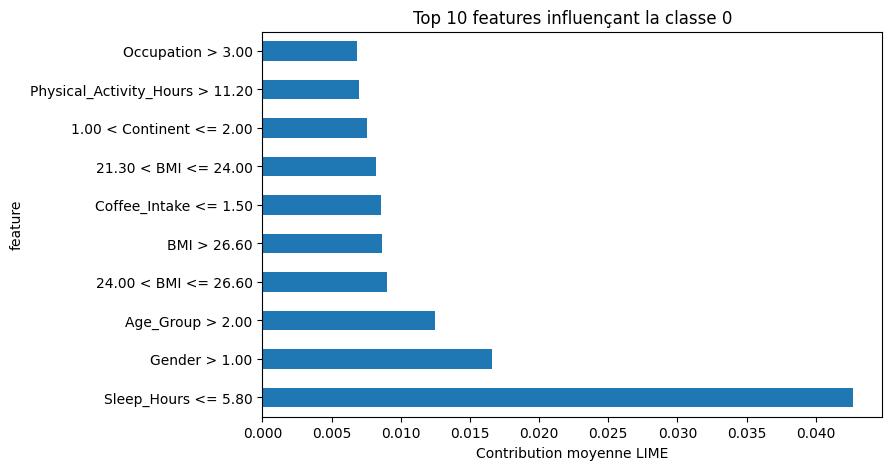

In [88]:
all_results = []

for i in range(min(50, len(grouped_indices[0]))):
    ligne = grouped_indices[0][i]
    sample = X_test.iloc[ligne]
    exp = explainer.explain_instance(sample.values, best_model.predict_proba)
    
    for feature, weight in exp.as_list():
        all_results.append({
            "index": ligne,
            "feature": feature,
            "weight": weight,
            "true_class": y_test.iloc[ligne]
        })

df_lime_0 = pd.DataFrame(all_results)
df_lime_0

import matplotlib.pyplot as plt

top_features = df_lime_0.groupby('feature')['weight'].mean().sort_values(ascending=False).head(10)
top_features.plot(kind='barh', figsize=(8,5))
plt.xlabel("Contribution moyenne LIME")
plt.title("Top 10 features influençant la classe 0")
plt.show()



c:\Users\akram\Processus_data\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\akram\Processus_data\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\akram\Processus_data\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\akram\Processus_data\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\akram\Processus_data\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature nam

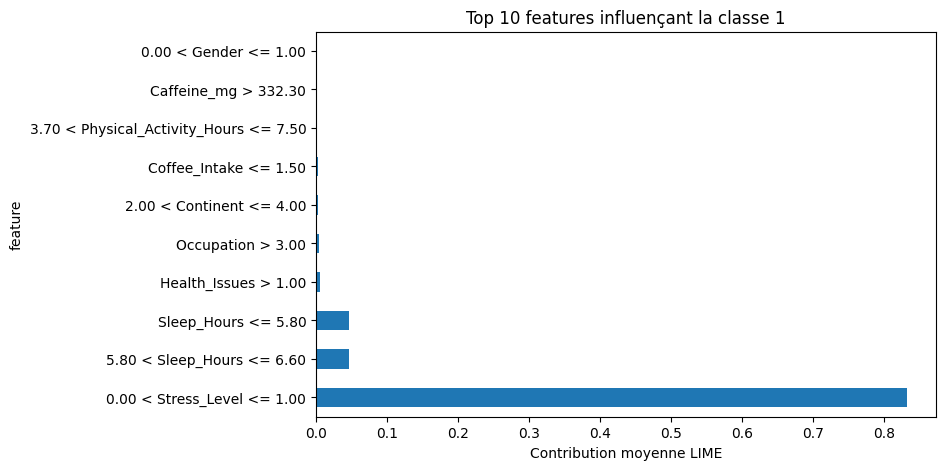

In [89]:
all_results = []

for i in range(min(50, len(grouped_indices[1]))):
    ligne = grouped_indices[1][i]
    sample = X_test.iloc[ligne]
    exp = explainer.explain_instance(sample.values, best_model.predict_proba)
    
    for feature, weight in exp.as_list():
        all_results.append({
            "index": ligne,
            "feature": feature,
            "weight": weight,
            "true_class": y_test.iloc[ligne]
        })

df_lime_1 = pd.DataFrame(all_results)
df_lime_1

import matplotlib.pyplot as plt

top_features = df_lime_1.groupby('feature')['weight'].mean().sort_values(ascending=False).head(10)
top_features.plot(kind='barh', figsize=(8,5))
plt.xlabel("Contribution moyenne LIME")
plt.title("Top 10 features influençant la classe 1")
plt.show()



c:\Users\akram\Processus_data\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\akram\Processus_data\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\akram\Processus_data\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\akram\Processus_data\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\akram\Processus_data\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature nam

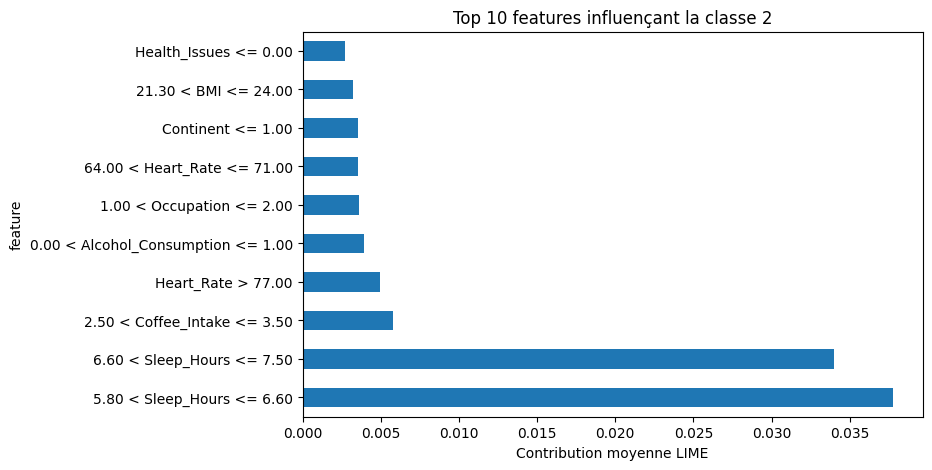

In [90]:
all_results = []

for i in range(min(50, len(grouped_indices[2]))):
    ligne = grouped_indices[2][i]
    sample = X_test.iloc[ligne]
    exp = explainer.explain_instance(sample.values, best_model.predict_proba)
    
    for feature, weight in exp.as_list():
        all_results.append({
            "index": ligne,
            "feature": feature,
            "weight": weight,
            "true_class": y_test.iloc[ligne]
        })

df_lime_2 = pd.DataFrame(all_results)
df_lime_2

import matplotlib.pyplot as plt

top_features = df_lime_2.groupby('feature')['weight'].mean().sort_values(ascending=False).head(10)
top_features.plot(kind='barh', figsize=(8,5))
plt.xlabel("Contribution moyenne LIME")
plt.title("Top 10 features influençant la classe 2")
plt.show()



c:\Users\akram\Processus_data\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\akram\Processus_data\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\akram\Processus_data\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\akram\Processus_data\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\akram\Processus_data\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature nam

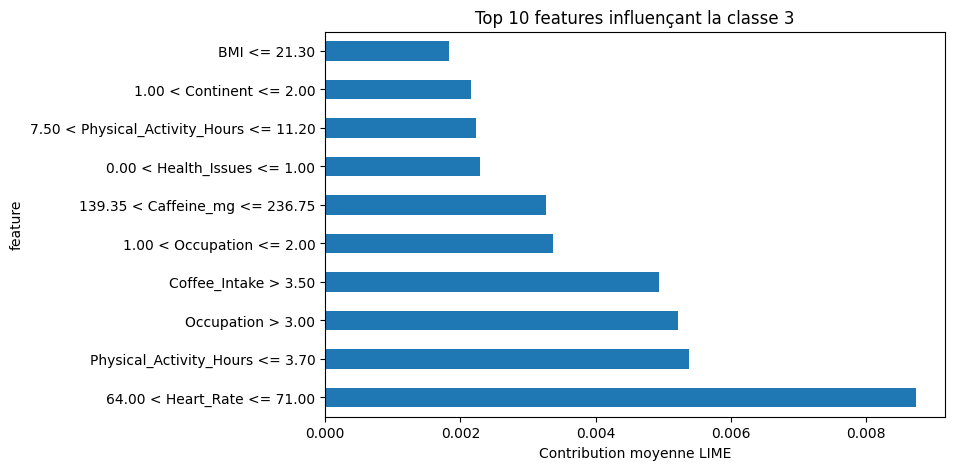

In [91]:
all_results = []

for i in range(min(50, len(grouped_indices[3]))):
    ligne = grouped_indices[3][i]
    sample = X_test.iloc[ligne]
    exp = explainer.explain_instance(sample.values, best_model.predict_proba)
    
    for feature, weight in exp.as_list():
        all_results.append({
            "index": ligne,
            "feature": feature,
            "weight": weight,
            "true_class": y_test.iloc[ligne]
        })

df_lime_3 = pd.DataFrame(all_results)
df_lime_3

import matplotlib.pyplot as plt

top_features = df_lime_3.groupby('feature')['weight'].mean().sort_values(ascending=False).head(10)
top_features.plot(kind='barh', figsize=(8,5))
plt.xlabel("Contribution moyenne LIME")
plt.title("Top 10 features influençant la classe 3")
plt.show()

